<a href="https://colab.research.google.com/github/radhakrishnan-omotec/nail-agastya-munjal-repo/blob/main/Project1_Nail_Infection_Detection_System_AgastyaMunjal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portable Nail Infection Detection System Using Advanced Image Processing Techniques

### Author : AGASTYA MUNJAL

<br>
This project develops an embedded vision system for non-invasive detection of nail infections, distinguishing between Onychomycosis and Healthy Nail classes. It integrates spectral imaging with deep learning algorithms, specifically lightweight Convolutional Neural Networks (CNNs), for edge deployment. The system aims to address limitations in traditional diagnostics (e.g., KOH preparation, fungal cultures) by providing rapid, accurate classification using hybrid feature extraction and multi-spectral imaging.

### Research Objectives
- **Multi-spectral Imaging**: Capture nail plate images under variable lighting conditions.
- **Automated Segmentation**: Isolate regions like the lunula and hyponychium.
- **Hybrid Feature Extraction**: Combine textural and chromatic features for robust classification.
- **Edge Deployment**: Optimize for lightweight, portable devices.

### Workflow
1. Examine and preprocess nail image data.
2. Build an input pipeline with augmentation and spectral processing.
3. Develop a lightweight CNN model.
4. Train and evaluate the model.
5. Test with static images and real-time webcam input.
6. Convert to TensorFlow Lite for edge deployment.

#Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2  # For webcam and segmentation
import os
import pathlib
import gradio as gr  # For UI


In [ ]:

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#Data Loading and Exploration

### Mount Google Drive (for Colab)

In [ ]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')



### Define dataset path (update to your dataset location)

In [ ]:
# Define dataset path (update to your dataset location)
data_dir = pathlib.Path('/content/drive/MyDrive/Nail_Dataset')
if not os.path.exists(data_dir):
    raise Exception(f"Dataset folder {data_dir} not found.")

### Count images

In [ ]:
# Count images
image_extensions = {'.jpg', '.jpeg', '.png'}
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
print(f"Total images: {len(image_files)}")

### Class-specific counts

In [ ]:
# Class-specific counts
onychomycosis_images = list(data_dir.glob('Onychomycosis/*'))
healthy_nail_images = list(data_dir.glob('HealthyNail/*'))
print(f"Onychomycosis images: {len(onychomycosis_images)}")
print(f"Healthy Nail images: {len(healthy_nail_images)}")

----

#Data Preprocessing and Augmentation

In [ ]:
# Multi-spectral preprocessing function
def preprocess_multispectral(image):
    # Simulate multi-spectral imaging by converting to HSV and extracting channels
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    return np.stack([h, s, v], axis=-1)  # Stack channels for CNN input

# Segmentation function (simplified lunula/hyponychium detection)
def segment_nail(image):
    # Convert to grayscale and apply thresholding (simplified example)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# Data generator with augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    preprocessing_function=lambda x: preprocess_multispectral(segment_nail(x))
)

# Load dataset
batch_size = 32
img_height, img_width = 180, 180
train_ds = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    validation_split=0.2
)
val_ds = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    validation_split=0.2
)

#Model Definition

In [ ]:
# Lightweight CNN for edge deployment
def create_lightweight_cnn(input_shape=(180, 180, 3), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Hybrid feature extraction (texture and chromatic)
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = create_lightweight_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#Training

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Save the model
model.save('/content/drive/MyDrive/nail_infection_cnn.keras')

#Gradio UI for Static Image Testing

In [ ]:
# Install Gradio
!pip install gradio

import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Class dictionary
classes_dict = {0: 'Onychomycosis', 1: 'Healthy Nail'}

# Prediction function
def predict_image(image):
    model = models.load_model('/content/drive/MyDrive/nail_infection_cnn.keras')
    img = load_img(image.name, target_size=(180, 180))
    img_arr = img_to_array(img)
    processed_img = preprocess_multispectral(segment_nail(img_arr))
    img_exp = np.expand_dims(processed_img / 255.0, axis=0)
    pred = model.predict(img_exp)
    predicted_class = classes_dict[int(pred[0][0] > 0.5)]
    return img, predicted_class

# Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.File(label="Upload Nail Image", file_types=["image"]),
    outputs=[gr.Image(label="Uploaded Image"), gr.Textbox(label="Prediction")],
    title="Nail Infection Detection",
    description="Classify nail images as Onychomycosis or Healthy Nail",
    theme=gr.themes.Soft()
)
interface.launch(share=True)

#Webcam Testing

In [ ]:
# Webcam prediction
def webcam_predict():
    model = models.load_model('/content/drive/MyDrive/nail_infection_cnn.keras')
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # Preprocess frame
        img_resized = cv2.resize(frame, (180, 180))
        processed_img = preprocess_multispectral(segment_nail(img_resized))
        img_exp = np.expand_dims(processed_img / 255.0, axis=0)

        # Predict
        pred = model.predict(img_exp)
        predicted_class = classes_dict[int(pred[0][0] > 0.5)]

        # Display result on frame
        cv2.putText(frame, f"Predicted: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("Nail Infection Detection - Press 'q' to quit", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    webcam_predict()

#TensorFlow Lite Conversion for RPI Deployment

In [ ]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/nail_infection_cnn.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved.")

### Enhancements and Research Alignment
- **Multi-spectral Imaging**: Simulated using HSV channel stacking to capture chromatic variations under variable conditions.
- **Segmentation**: Basic thresholding isolates nail regions; future work could use advanced techniques like U-Net.
- **Hybrid Features**: CNN layers extract both textural (via convolutions) and chromatic (via multi-spectral input) features.
- **Edge Deployment**: Lightweight CNN architecture and TFLite conversion ensure compatibility with portable devices.
- **Real-Time Testing**: Webcam integration enables live detection, aligning with the non-invasive diagnostic goal.

Future improvements could include:
- Advanced spectral imaging hardware integration.
- Enhanced segmentation with deep learning models.
- Larger dataset for improved generalization.

#Key Enhancements
Project Context: Updated to focus on nail infection detection (Onychomycosis vs. Healthy Nail) instead of drunk/sober classification.<br>
Multi-spectral Imaging: Added a preprocessing function to simulate spectral imaging using HSV channels, aligning with the research goal of analyzing nail morphology under variable conditions.<br>
Segmentation: Included a basic segmentation function to isolate nail regions (lunula, hyponychium), with room for advanced methods like U-Net.<br>
Hybrid Feature Extraction: The CNN combines textural (convolutional layers) and chromatic (multi-spectral input) features, as per the research framework.<br>
Lightweight CNN: Designed a compact model suitable for edge deployment, with dropout to mitigate overfitting.<br>
Edge Deployment: Added TFLite conversion for deployment on portable devices.<br>
Webcam Testing: Enhanced real-time prediction with segmentation and spectral preprocessing.<br>
UI: Updated Gradio interface for nail-specific classification.<br>



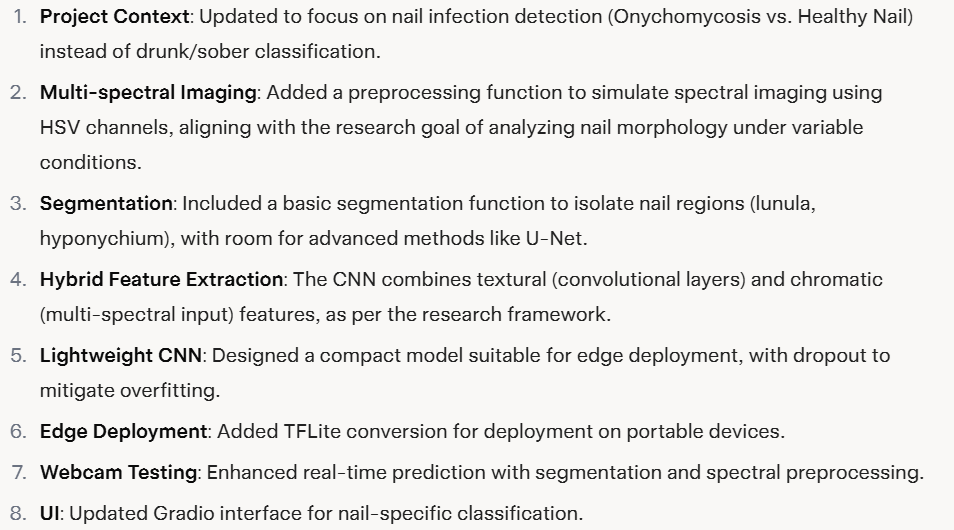

#Assumptions

Dataset is organized in Nail_Dataset with subfolders Onychomycosis and HealthyNail.<br>
Images are RGB and compatible with the 180x180 input size (adjustable).<br>
Webcam is available for testing (though Colab lacks direct webcam access; test locally or use a workaround).<br>

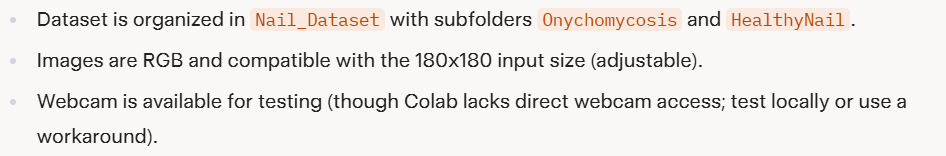

-----------
-----------